In [39]:
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np

# Lecture 4: Models of causal exposure and identification criteria for conditioning estimators

## Introduction

**Approaches to the estimation of causal effects**

* conditioning on variable that block all back-door paths from the causal variable to the outcome variable

* using exogenous variation in an appropriate instrumental variable to isolate covariation in the causal variable and the outcome variable

* establishing the exhaustive and isolated mechanism that intercepts the effect of the causal variable on the outcome variable and then calculating the causal effect as it propagates through the mechanisms

## Conditioning and directed graphs

<img src="material/fig-backdoor-path.png" width="300" />

This graph is an example where a simple mean-comparison between the treated and untreated is not informative on the effect of the treatment.

* The total association between $D$ and $Y$ is an unknown composite of the true causal effect $D \rightarrow Y$ and the noncausal association between $D$ and $Y$.

**Conditioning strategies**

* balancing the determinants of treatment assignment (e.g. matching estimators)

* adjusting for all other causes of the outcome (e.g. regression estimators)


**Back-door path**

A back-door path is a path between any causally ordered sequence of two variables that begins with a directed edge that points to the first variable.


**LaLonde dataset**

What was the graph behind our analysis of the Lalonde dataset?

<img src="material/fig-implicit-lalonde.png" width="500" />

### Illustration of collider variables

We introduced collider variables earlier. However, they will play a very important role going forward and thus we study in an illustration how conditioning on a **collider** induces a conditional association between two variables without an unconditional association.

<img src="material/fig-collider-variable.png" width="500" />


In [32]:
num_individuals = 250

# Initialize empty data frame
columns = ["SAT", "motivation", "admission"]
df = pd.DataFrame(columns=columns, index=range(num_individuals))

df["motivation"] = np.random.normal(size=num_individuals)
df["SAT"] = np.random.normal(size=num_individuals)

# Both toghether determine college admission
score = df["motivation"] + df["SAT"]
cutoff = np.percentile(df["motivation"] + df["SAT"], 85)
df["admission"] = score > cutoff
df.head()

,SAT,motivation,admission
0,-0.215015,0.689090,False
1,0.322204,-1.139126,False
2,-0.405829,-0.125679,False
3,-0.983681,0.275597,False
4,-0.717527,0.187687,False


The Pearson correlation coefficient is   0.005


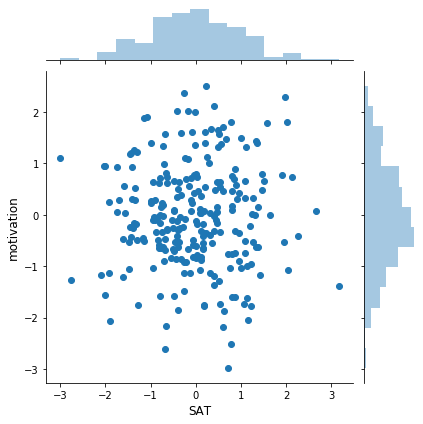

In [36]:
def get_joint_distribution(df):
    sns.jointplot("SAT", "motivation", df)

    stat = stats.pearsonr(df["SAT"], df["motivation"])[0]
    print(f"The Pearson correlation coefficient is {stat:7.3f}")


get_joint_distribution(df)

What happens if we condition on college admittance $C$, i.e. on a collider variable?

The Pearson correlation coefficient is  -0.712


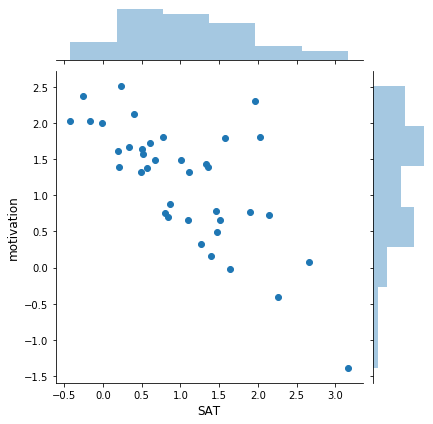

In [37]:
get_joint_distribution(df.query("admission == True"))

Conditioning on a collider variable that lies along a back-door path does not help to block
the back-door path but instead creates new associations.

## The back-door criterion

The **back-door** criterion allows to determine the whether or not conditioning on a given set of observed variables will identify the causal effect of interest.


* **Step 1** Write down the back-door paths from the causal variable to the outcome variable, determine which ones are unblocked, and then search for a candidate conditioning set of observed variables that will block all unblocked back-door paths.

* **Step 2** If a candidate conditioning set is found that blocks all back-door paths, inspect the patterns of decent in the graph in order to verify that the variables in the candidate conditioning set do not block or otherwise adjust away any portion of the causal effect of interest.


If one or more back-door paths connect the causal variable to the outcome variable, the causal effect is identified by conditioning on a set of variables $Z$ if 

**Condition 1** All back-door paths between the causal variable and the outcome variable are blocked after conditioning on $Z$, which will always be the case if each back-door path

* contains a chain of mediation $A\rightarrow C \rightarrow B$ where the middle variable $C$ is in $Z$ 

* contains a fork of mutual dependence $A \leftarrow C \rightarrow B$, where the middle variable $C$ is in $Z$

* contains an inverted fork of mutual causation $A \rightarrow C \leftarrow B$, where the middle variable $C$ and all of $C$'s decendents are **not** in $Z$

and ...



**Condition 2** No variables in $Z$ are decendents of the causal variable that lie on (or decend from other variables that lie on) any of the directed paths that begin at the causal variable and reach the outcome variable.

Let's revisit our example earlier:

<img src="material/fig-backdoor-path.png" width="300" />

* chain of mediation

* fork of mutual dependence


We will now work through two more advanced examples where we focus on only the first conditions of the back-door criterion.

* Let's start with a simple example and apply the idea of back-door identification to a graph where we consider conditioning on a lagged outcome variable $Y_{t -1}$.

<img src="material/fig-backdoor-example-1.png" width="500" />

* $Y_{t - 1}$ lies on both back-door paths but it does not satisfy the back-door criterion. It blocks one path, but is a collider variable on the other

Let us practice our understanding for some interesting graph structures. The backdoor algorithm is also available [here](https://nbviewer.jupyter.org/github/HumanCapitalAnalysis/microeconometrics/blob/master/lectures/04_criteria_conditioning_estimators/back_door_algorithm.ipynb) for your reference.

Here are a couple of candidates conditioning sets.

* $\{F\}$
* $\{A\}$
* $\{A, B\}$

<img src="material/fig-backdoor-example-2.png" width="500" />

Finally, let's focus on the second condition.

* **Condition 2** No variables in $Z$ are decendents of the causal variable that lie on (or decend from other variables that lie on) any of the directed paths that begin at the causal variable and reach the outcome variable.

We first look at a graph that illustrates what a descendent is and remind ourselves of the difference between a direct and an indirect effect.

<img src="material/fig-backdoor-indirect-effect.png" width="300" />

Conditioning on $N$ (in addition to either $N$ or $O$) does not satisfy the back-door criterion due to its violation of the second condition.

Let's evaluate the following conditioning set: $\{O, B\}$.

<img src="material/fig-backdoor-condition-2.png" width="300" />

## Models of causal exposure and point identification based on potential outcome model

### Treatment assignment modeling in statistics

Treatment assignment patterns are represented by a general conditional probability distribution often referred to as propensity scores:

\begin{align*}
\Pr[D = 1 \mid S], 
\end{align*}
where $S$ denotes all variables that systematically determine treatment assignment.

* In the case of a randomized experiment we know the propensity score, while we have to estimate it in observational studies.


If all variables in $S$ are observed, then treatment assignment is ignorable
\begin{align*}
(Y^0, Y^1) \perp \!\!\! \perp D \mid S 
\end{align*}

Within the strata defined by $S$, the remaining variation in $D$ is random  and hence the process that generates these remaining variations is ignorable.

**Strategy to ensure ignorable treatment assignment**

* determine from related studies and supportable assumptions grounded in theory what the components of $S$ are

* measure each of the components in $S$

* collect enough data to be able to considerably estimate outcome differences on the observed variable $Y$ within strata defined by $S$

<img src="material/fig-assignment-statistics.png" width="500" />

### Treatment selection modeling in econometrics

\begin{align*}
Y & = D Y^1 + (1 - D) Y^0 \\
& = Y^0 + D(Y^1 - Y^0) \\
& = Y^0 + \delta D \\
& = \mu^0 + \delta D + \nu^0,
\end{align*}

where $\mu^0 \equiv E[Y^0]$ and $\nu^0 \equiv Y^0 - E[Y^0]$.

Let's emphasize potential treatment effect heterogeneity:

\begin{align*}
Y = \mu^0 + ( \mu^1 - \mu^0) D + \{\nu^0 + D(\nu^1 - \nu^0)\}
\end{align*}
where $\mu^1 \equiv E[Y^1]$ and $\nu^1 \equiv Y^1 - E[Y^1]$.

Let's introduce a latent variable to be more precise about the 

\begin{align*}
\tilde{D} = Z\phi + U, 
\end{align*}

where $U$ contains systematic unobserved determinants of treatment selection and completely random components.

The latent continuous variable $D$ is then related to our treatment selection dummy as follows.

\begin{align*}
D = \begin{cases}
1 & \quad\text{if}\quad \tilde{D} > 0 \\
0 & \quad\text{otherwise}
\end{cases}
\end{align*}


**Selection on observables and unobservables**

<img src="material/fig-assignment-econometrics.png" width="500" />

Link to the literature on treatment assignment in statistics:

* $Z$ equals $S$  $\rightarrow$ selection on observables
* $Z$ is only a subset of $S$ $\rightarrow$ selection on unobservables